# Project 2: Exploratory Analysis

Julian Himes  
February 3, 2017

## Intro

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest
import numpy as np
import statsmodels.api as sm
from statsmodels.api import Probit

%matplotlib inline

In [2]:
# Read in data from source 
df = pd.read_csv("../assets/admissions.csv")
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Questions

In [3]:
# How many observations are in our dataset?
len(df)

400

In [4]:
# Create a summary table
df.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


In [5]:
# Why does GRE have a much larger standard deviation than GPA? 
# Because GRE data has a much wider range than GPA data, and the data varies more within that range:

gre_range = df.gre.max() - df.gre.min()
gpa_range = round(df.gpa.max() - df.gpa.min(), 2)

print 'GRE range: %r' % gre_range
print 'GPA range: %r' % gpa_range

GRE range: 580.0
GPA range: 1.74


In [6]:
# Check for missing data
df.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [7]:
# Drop data points with missing data
df_clean = df.dropna()

In [8]:
# Confirm that you dropped the correct data
df_clean.isnull().sum()

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

This sums all the boolean results for "isnull" for all variables in the dataset. If any values were missing, then they would return True (1) for isnull. Given that all variables sum to 0, we can say that none of the variables have any "isnull" results of True, i.e. all are False/0, i.e. no values are missing.

In [9]:
len(df_clean)

397

Having dropped 3 observations with missing values, we have 397 records remaining in our cleaned dataset.

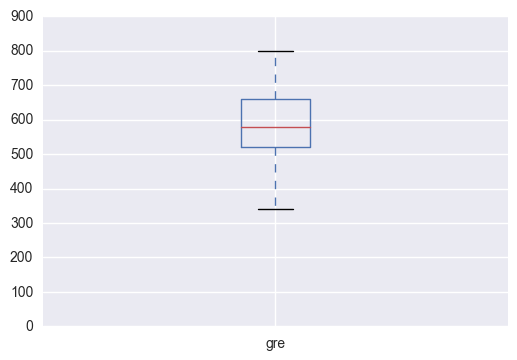

In [10]:
# Create a boxplot for GRE
ax1 = df_clean['gre'].plot(kind="box")
ax1.set_ylim(0,900)
ax1;

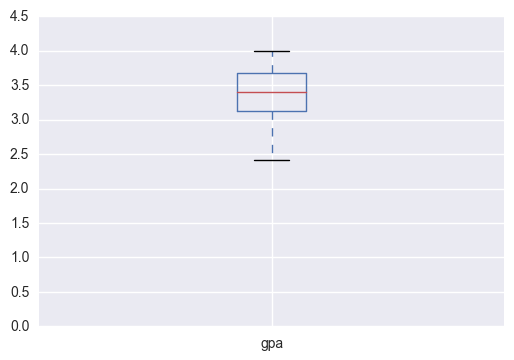

In [11]:
# Create a boxplot for GPA
ax2 = df_clean['gpa'].plot(kind="box")
ax2.set_ylim(0, 4.5)
ax2;

These plots show relatively normal distributions for both GRE and GPA, with few outliers. GRE in particular looks very normal/symmetrical, with two outliers at the low end. GPA is slightly left-skewed, with one outlier at the low end.

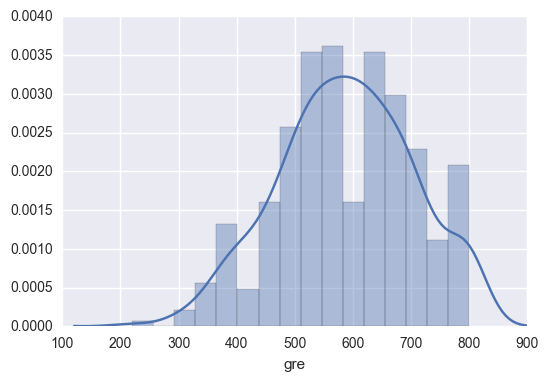

In [12]:
# Check distribution for GRE
sns.distplot(df_clean.gre);

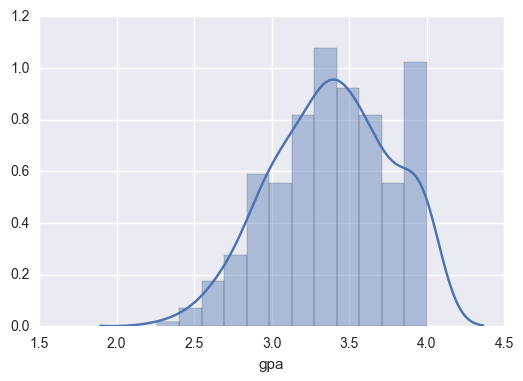

In [13]:
# Check distribution for GPA
sns.distplot(df_clean.gpa);

For both GRE and GPA it looks like there are several perfect scores, meaning that there are many observations at the top of the distribution. Otherwise, these still look fairly normal.

In [14]:
# How many students had a perfect score on the GRE? How many had a perfect GPA?
perfGRE = df_clean.gre[df_clean.gre == 800].count()
perfGPA = df_clean.gpa[df_clean.gpa == 4.0].count()

print "Perfect GRE: %r" % perfGRE
print "Perfect GPA: %r" % perfGPA

Perfect GRE: 25
Perfect GPA: 28


In [15]:
# How many students had both? Were they all admitted?
perf = df_clean.admit[(df_clean.gpa == 4.0) & (df_clean.gre == 800)].count()

print "Perfect GRE and GPA: %r" % perf

df_clean[(df_clean.gpa == 4.0) & (df_clean.gre == 800)]

Perfect GRE and GPA: 5


,admit,gre,gpa,prestige
2,1,800.0,4.0,1.0
10,0,800.0,4.0,4.0
33,1,800.0,4.0,3.0
77,1,800.0,4.0,3.0
377,1,800.0,4.0,2.0


In [16]:
# Do a normality test on the data
a, pval_gre = normaltest(df_clean['gre'])
b, pval_gpa = normaltest(df_clean['gpa'])

print "P-value for GRE: %r" % pval_gre
print "P-value for GPA: %r" % pval_gpa

P-value for GRE: 0.14822980613776662
P-value for GPA: 0.001444578377229117


#### Q: If our model had an assumption of a normal distribution would we meet that requirement? 

A: If we required our independent variables to be normally distributed, we would not meet that assumption for GPA. Generally, regression models only require residuals to be normally distributed.

#### Q: Does this distribution need correction? If so, why? How? 

A: No. 

#### Q: Which of our variables are potentially colinear? 

A: GRE and GPA could be collinear, since they both are a measure of student performance. Presumably students with high GPA would also perform well on the GRE. 

Prestige and GRE could also be collinear, since students who went to better undergraduate institutions would likely perform better on the GRE.

In [17]:
# Create a correlation matrix for the data
df_clean.corr()

,admit,gre,gpa,prestige
admit,1.000000,0.181202,0.174116,-0.243563
gre,0.181202,1.000000,0.382408,-0.124533
gpa,0.174116,0.382408,1.000000,-0.060976
prestige,-0.243563,-0.124533,-0.060976,1.000000


#### Q: What did you find?

A: GRE and GPA are positively correlated (0.38) but not strongly enough to indicate multicollinearity. Prestige and GRE are weakly correlated (-0.12), indicating that as the prestige rank number increases, i.e. the school is a lower rank and is lower quality, student performance on the GPA decreases.

#### Q: Write an analysis plan for exploring the association between grad school admissions rates and prestige of  undergraduate schools.

A: Having cleaned the data to remove observations with missing values, reviewed summary statistics and distributions for the variables in the model, and checked correlations among the explanatory variables, I want to create a model that uses prestige of undergraduate schools to predict the probability of a student getting admitted to grad school. The model will also include GRE and GPA as covariates to control for these factors, isolating the independent effect of 'prestige' on admission.

#### Q: What is your hypothesis? 

A: Students who went to schools that are lower in prestige (i.e. have a higher prestige rank number) are less likely to be admitted to graduate school.

In [18]:
# Run probit model
df_exog = sm.add_constant(df_clean.loc[:,['gre', 'gpa','prestige']])
df_endog = df_clean['admit']
probit_mod = sm.Probit(df_endog, df_exog)
probit_res = probit_mod.fit()
print probit_res.summary()

Optimization terminated successfully.
         Current function value: 0.575051
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                         Probit   Df Residuals:                      393
Method:                           MLE   Df Model:                            3
Date:                Sun, 05 Feb 2017   Pseudo R-squ.:                 0.07974
Time:                        15:14:11   Log-Likelihood:                -228.30
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.318e-08
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -2.0261      0.675     -3.001      0.003        -3.349    -0.703
gre            0.0014      0.

These results indicate that when 'prestige' is increased by 1, the probability of 'admit'=1 decreases by 0.33. In other words, all else held constant, a student who went to an undergraduate school ranked #1 is 33% more likely to be admitted to graduate school than a student who went to a school ranked #2.

## Bonus/Advanced

#### 1. Bonus: Explore alternatives to dropping observations with missing data

Rather than dropping observations with missing data, we could:
* Replace those values with zeroes
* Replace those values with the median value for that variable
* Replace those values with the mean value for that variable

#### 2. Bonus: Log transform the skewed data

In [19]:
# Generate a variable for the log of GPA and add in to dataset
df_log = df_clean.copy()
df_log['log_gpa'] = df_clean['gpa'].apply(np.log10)
df_log.head()

,admit,gre,gpa,prestige,log_gpa
0,0,380.0,3.61,3.0,0.557507
1,1,660.0,3.67,3.0,0.564666
2,1,800.0,4.00,1.0,0.602060
3,1,640.0,3.19,4.0,0.503791
4,0,520.0,2.93,4.0,0.466868


In [20]:
# Check for normality of log GPA
a, pval_lgpa = normaltest(df_log['log_gpa'])

print "P-value for log GPA: %r" % pval_lgpa

P-value for log GPA: 0.00075117963919804696


(This seems worse? Less normally distributed at least?)

#### 3. Advanced: Impute missing data

In [21]:
# Check for locations of missing values
df[df.isnull().any(axis=1)]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
212,0,NaN,2.87,2.0
236,1,660.0,NaN,NaN


In [22]:
# Fill missing values with the mean for that column
df_means = df.fillna(df.mean())

In [23]:
# Double-check that the imputation worked
gre_mean = df.gre.mean()
gpa_mean = df.gpa.mean()
prst_mean = df.prestige.mean()

print 'GRE mean: %r' % gre_mean
print 'GPA mean: %r' % gpa_mean
print 'Prestige mean: %r' % prst_mean

GRE mean: 588.0402010050251
GPA mean: 3.3909296482412077
Prestige mean: 2.4862155388471177


In [24]:
# Check row 187
df_means[187:188]

,admit,gre,gpa,prestige
187,0,588.040201,3.39093,2.0


In [25]:
# Check row 212
df_means[212:213]

,admit,gre,gpa,prestige
212,0,588.040201,2.87,2.0


In [26]:
# Check row 236
df_means[236:237]

,admit,gre,gpa,prestige
236,1,660.0,3.39093,2.486216
